In [7]:
import crypto_package as cp
from crypto_package.fake_bot.fake_bot import FakeBot
from crypto_package.fake_bot.models import AnalysisResult,Trade
from crypto_package.fake_bot.analyze_functions import plot_profit, plot_pairs_profit, plot_block_profit, plot_balance
import talib.abstract as ta
from pandas import to_datetime, DataFrame
from typing import List

In [8]:
import plotly.graph_objects as go
from datetime import datetime

def get_candles_and_plot(exchange: str, pair: str, candle_size: str, time_start:datetime = None, time_end:datetime=None, last_n_candles:int=None, trades:AnalysisResult=None, width:int=1000, height:int=600):
    candles, _= cp.get_candles(exchange, pair, candle_size, last_n_candles=last_n_candles, time_start=time_start, time_end=time_end)
    
    # candles = candles.rename(columns={"time": "date"})
    # candles["date"] = to_datetime(candles["date"], unit='s')
    
    fig = plot_candles(candles, trades, pair, width, height)
    # return fig
    return candles
    


In [9]:
import plotly.graph_objects as go
from datetime import datetime

def plot_candles(candles:DataFrame, trades:AnalysisResult=None, pair=None, width:int=1000, height:int=650):   
    
    if "time" in candles.columns:
        candles = candles.rename(columns={"time": "date"})
    if type(candles["date"][0]) is not datetime:
        candles["date"] = to_datetime(candles["date"], unit='s')
    
    fig = go.Figure()
    fig.add_trace(go.Candlestick(
                    x=candles['date'],
                    open=candles['open'],
                    high=candles['high'],
                    low=candles['low'],
                    close=candles['close']))
    
    if trades!=None:
        res = trades.trades
        
        if pair!=None:
            res = [t for t in trades.trades if t.pair==pair]
        
        
        buy_trades_price = [tr.price for tr in res if tr.is_buy]
        buy_trades_time = [tr.timestamp for tr in res if tr.is_buy]

        sell_trades_price = [tr.price for tr in res if not tr.is_buy]
        sell_trades_time = [tr.timestamp for tr in res if not tr.is_buy]
        
        fig.add_trace(go.Scatter(
            x=buy_trades_time,
            y=buy_trades_price,
            mode = 'markers',
            name='buy trades',
            marker_symbol='diamond',
            marker=dict(
                color='blue',
                line_width=2,
                size=7,

            )
        ))
        
        fig.add_trace(go.Scatter(
            x=sell_trades_time,
            y=sell_trades_price,
            mode = 'markers',
            name='sell trades',
            marker_symbol='square',
            marker=dict(
                color='yellow',
                line_width=2,
                size=7
            )
        ))
        
    
    fig.update_layout(
        title="Candles",
        xaxis_title="time",
        yaxis_title="price",
        width=width,
        height=height
    )
    
    fig.show()
    # return fig
    

In [10]:
def plot_indicators(indicators_df: DataFrame, indicators: List[str], width:int=1000, height:int=650): # indicators_df contains columns with indicators and column "date" with datetime
    if "time" in indicators_df.columns:
        indicators_df = indicators_df.rename(columns={"time": "date"})
    if type(indicators_df["date"][0]) is not datetime:
        indicators_df["date"] = to_datetime(indicators_df["date"], unit='s')
    
    for ind in indicators:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=indicators_df['date'],
            y=indicators_df[ind],
            mode = 'lines',
            name=ind,
        ))
        fig.update_layout(
            title=ind,
            xaxis_title="time",
            yaxis_title="value",
            width=width,
            height=height
        )
        fig.show()



In [19]:
from datetime import timedelta, datetime
def calculate_profit_from_trades(transactions:List[Trade], start_datetime, end_datetime):
    transactions.sort(key=lambda x: x.timestamp)
    tr_buy_amount = {}
    start = 0
    end = len(transactions)
    profit = 0
    sell_costs = 0
    buy_costs = 0
    
    x_v = [start_datetime]
    y_v = [profit]

    for trade_id in range(start, end):
        trade = transactions[trade_id]
        results = []
        if trade.amount in tr_buy_amount.keys():
            results = tr_buy_amount.get(trade.amount)
        
        if trade.is_buy:
            if len(results) == 0:
                results = [trade]
            else:
                results.append(trade)
            tr_buy_amount.update({trade.amount: results})
        else:
            oldest_buy = results.pop(0)
            if len(results) > 0:
                tr_buy_amount.update({trade.amount: results})
            else:
                tr_buy_amount.pop(trade.amount)

            sell_costs += trade.amount * trade.price
            buy_costs += trade.amount * oldest_buy.price
            profit = (sell_costs - buy_costs)/buy_costs
            # profit = ((trade.amount * trade.price) - (trade.amount * oldest_buy.price)) / (
            #             trade.amount * oldest_buy.price)

            y_v.append(profit)
            x_v.append(trade.timestamp)                  
            
    x_v.append(end_datetime)
    y_v.append(profit)
        
    return x_v, y_v


def plot_profit(trades: AnalysisResult, width:int=1000, height:int=650):
    x, y = calculate_profit_from_trades(trades.trades, trades.start_datetime, trades.end_datetime)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode = 'lines+markers',
        name="profit",
    ))
    fig.update_layout(
        title='BacktestingBots profit',
        xaxis_title="time",
        yaxis_title="value [%]",
        width=width,
        height=height
    )
    fig.show()

    # return fig

In [20]:
def plot_profit_per_pair(trades: AnalysisResult, pairs:List[str]=None, width:int=1000, height:int=650):
    pair_trades = {}
    
    if pairs==None:
        for trade in trades.trades:
            uptrades = pair_trades.get(trade.pair) if trade.pair in pair_trades.keys() else []
            uptrades.append(trade)
            pair_trades.update({trade.pair:uptrades})
    else:
        for trade in trades.trades:
            if trade.pair in pairs:
                uptrades = pair_trades.get(trade.pair) if trade.pair in pair_trades.keys() else []
                uptrades.append(trade)
                pair_trades.update({trade.pair:uptrades})
    
    fig = go.Figure()
    for pair, transactions in pair_trades.items():
        x, y = calculate_profit_from_trades(transactions, trades.start_datetime, trades.end_datetime)
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode = 'lines+markers',
            name=str(pair),
        ))
    
    calc_pairs = [item for item in pair_trades.keys()]
    fig.update_layout(
        title='BacktestingBots profit per pair '+str(calc_pairs),
        xaxis_title="time",
        yaxis_title="value [%]",
        width=width,
        height=height
    )
    fig.show()

In [21]:
# def calc_indicators(candles):
#         candles['rsi'] = ta.RSI(candles, timeperiod=14)
#         return candles

# def check_sell_signals(indicators):
#     if indicators.iloc[-1]['rsi'] < 32:
#         return True
#     else:
#         return False

# def check_buy_signals(indicators):
#     if indicators.iloc[-1]['rsi'] < 70:
#         return True
#     else:
#         return False

def calc_indicators(candles):
        candles['rsi'] = ta.RSI(candles, timeperiod=14)
        candles['ema'] = ta.EMA(candles, timeperiod=9)
        return candles

def check_buy_signals(indicators):
    if (indicators.iloc[-1]['rsi'] < 32 and
        indicators.iloc[-2]['rsi'] < indicators.iloc[-1]['rsi']):
        return True
    else:
        return False

def check_sell_signals(indicators):
    if (indicators.iloc[-1]['rsi'] > 70 and
        indicators.iloc[-2]['rsi'] > indicators.iloc[-1]['rsi']):
        return True
    else:
        return False

# def calc_indicators(candles):
#         candles['rsi'] = ta.RSI(candles, timeperiod=14)
#         candles['ema'] = ta.EMA(candles, timeperiod=9)
#         return candles

# def check_buy_signals(indicators):
#     if (indicators.iloc[-1]['rsi'] < 50 and
#         indicators.iloc[-2]['rsi'] < indicators.iloc[-1]['rsi']):
#         return True
#     else:
#         return False

# def check_sell_signals(indicators):
#     if (indicators.iloc[-1]['rsi'] > 50 and
#         indicators.iloc[-2]['rsi'] > indicators.iloc[-1]['rsi']):
#         return True
#     else:
#         return False

fbot = FakeBot("simple_strategy/config.yml")
res0 = fbot.test_strategy(calc_indicators, check_buy_signals, check_sell_signals, last_n_days=20)

/tmp/ipykernel_67/4177796267.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_67/4177796267.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



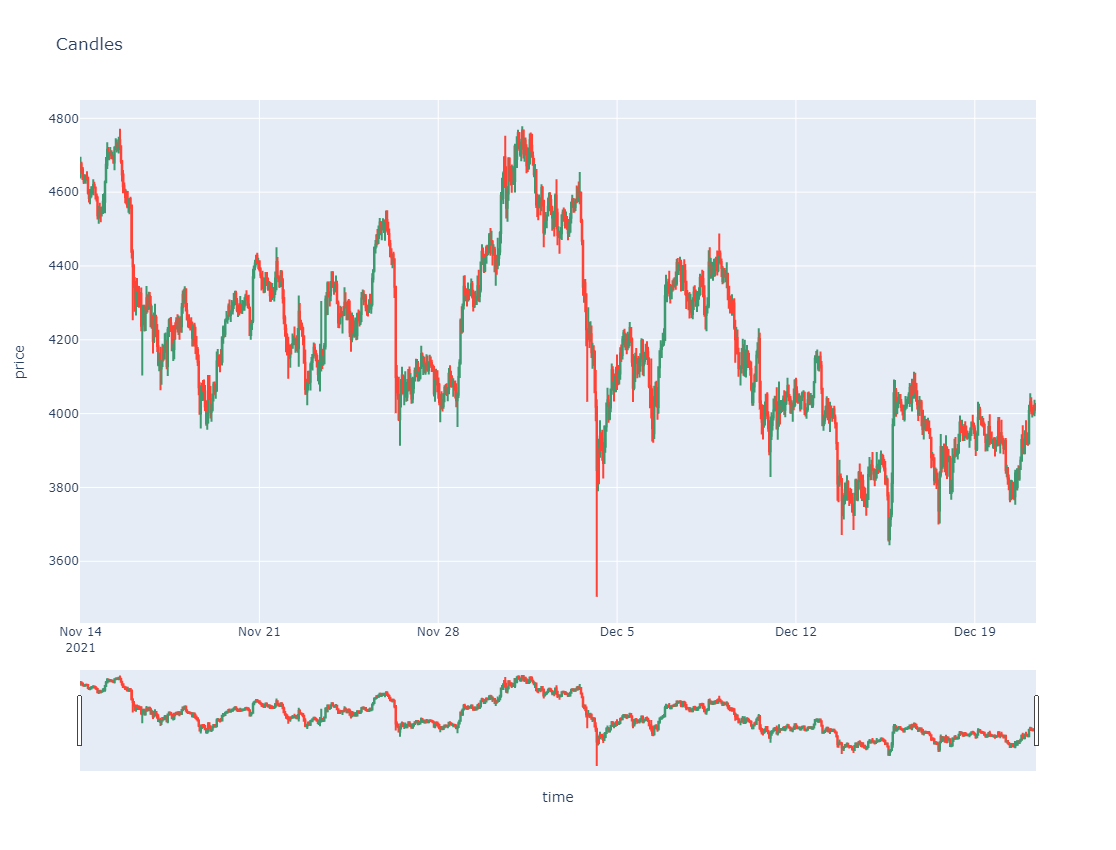

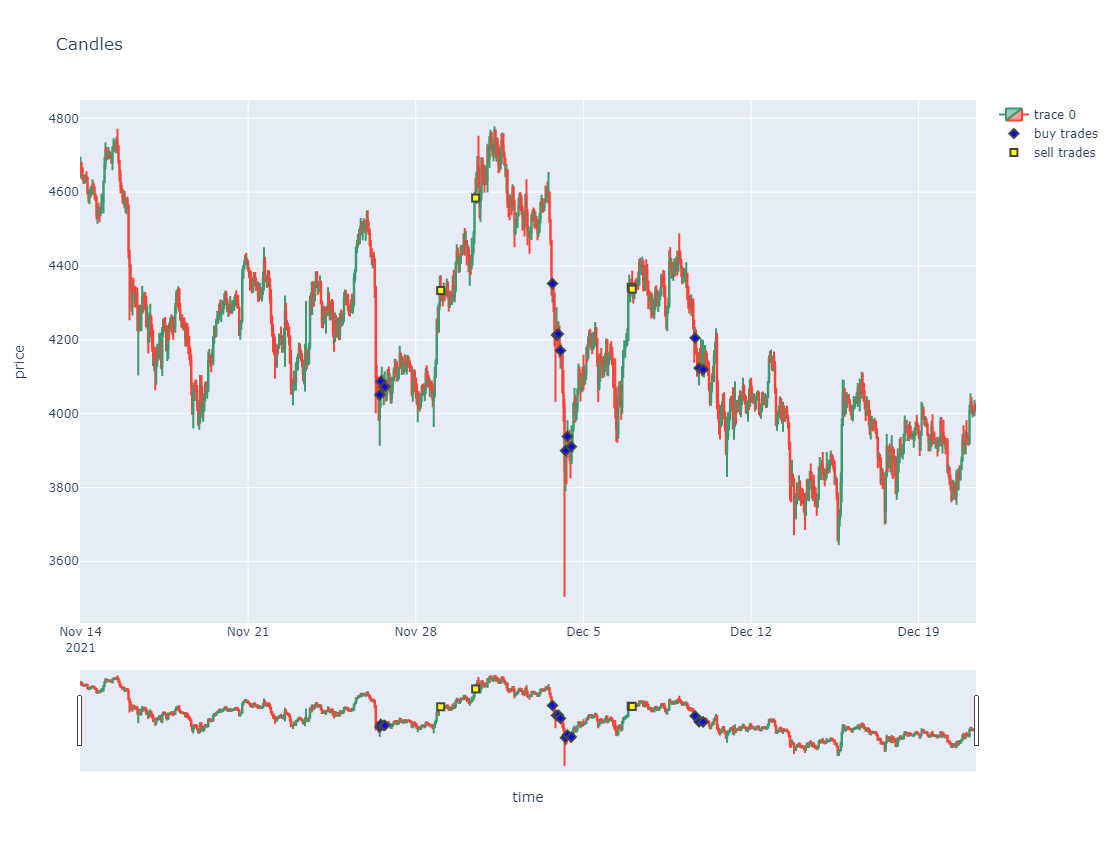

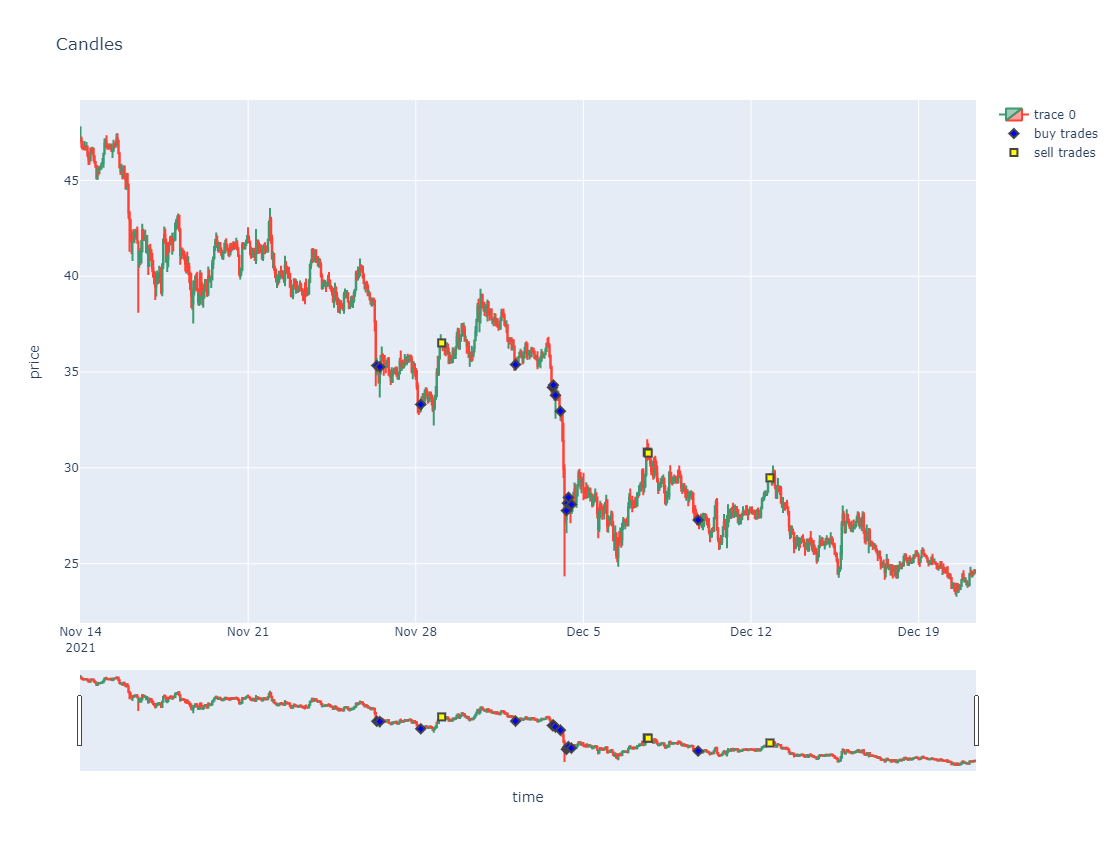

,close,high,low,open,time,volume
0,47.15,47.83,47.06,47.07,1636848000,400823.76
1,46.93,47.29,46.69,47.15,1636851600,187429.51
2,46.67,47.07,46.63,46.93,1636855200,161092.41
3,46.63,46.77,46.58,46.68,1636858800,124724.73
4,46.76,47.05,46.61,46.64,1636862400,196922.65
...,...,...,...,...,...,...
893,24.41,24.68,24.29,24.51,1640062800,391086.47
894,24.57,24.58,24.28,24.41,1640066400,373290.71
895,24.50,24.58,24.38,24.57,1640070000,239005.30
896,24.65,24.72,24.44,24.51,1640073600,401413.48


In [22]:
candles = get_candles_and_plot('binance', 'ETH/USDT', '1h', time_start=datetime(2021, 11, 14), width=1500, height=850)
get_candles_and_plot('binance', 'ETH/USDT', '1h', time_start=datetime(2021, 11, 14),  trades=res0, width=1500, height=850)
get_candles_and_plot('binance', 'DOT/USDT', '1h', time_start=datetime(2021, 11, 14),  trades=res0, width=1500, height=850)


In [23]:
candles['rsi'] = ta.RSI(candles, timeperiod=14)
candles['ema'] = ta.EMA(candles, timeperiod=9)
print(candles)

       close     high      low     open        time      volume        rsi  \
0    4675.47  4696.05  4636.83  4644.27  1636848000  13798.0553        NaN   
1    4661.41  4682.60  4650.00  4675.47  1636851600   7442.8086        NaN   
2    4635.65  4667.81  4633.56  4661.41  1636855200   6752.0164        NaN   
3    4628.63  4648.01  4621.81  4635.64  1636858800   7271.0019        NaN   
4    4633.40  4648.47  4625.31  4628.63  1636862400   4688.0207        NaN   
..       ...      ...      ...      ...         ...         ...        ...   
893  4011.38  4044.65  3998.29  4031.12  1640062800  17269.8045  63.316572   
894  4013.46  4017.69  3989.32  4011.22  1640066400  12017.3706  63.520661   
895  4003.21  4024.00  3995.51  4013.46  1640070000  12511.4583  61.698982   
896  4018.86  4037.73  3992.90  4003.37  1640073600  19435.0260  63.423752   
897  4018.01  4029.00  4007.57  4018.85  1640077200  10580.3220  63.257135   

             ema  
0            NaN  
1            NaN  
2     

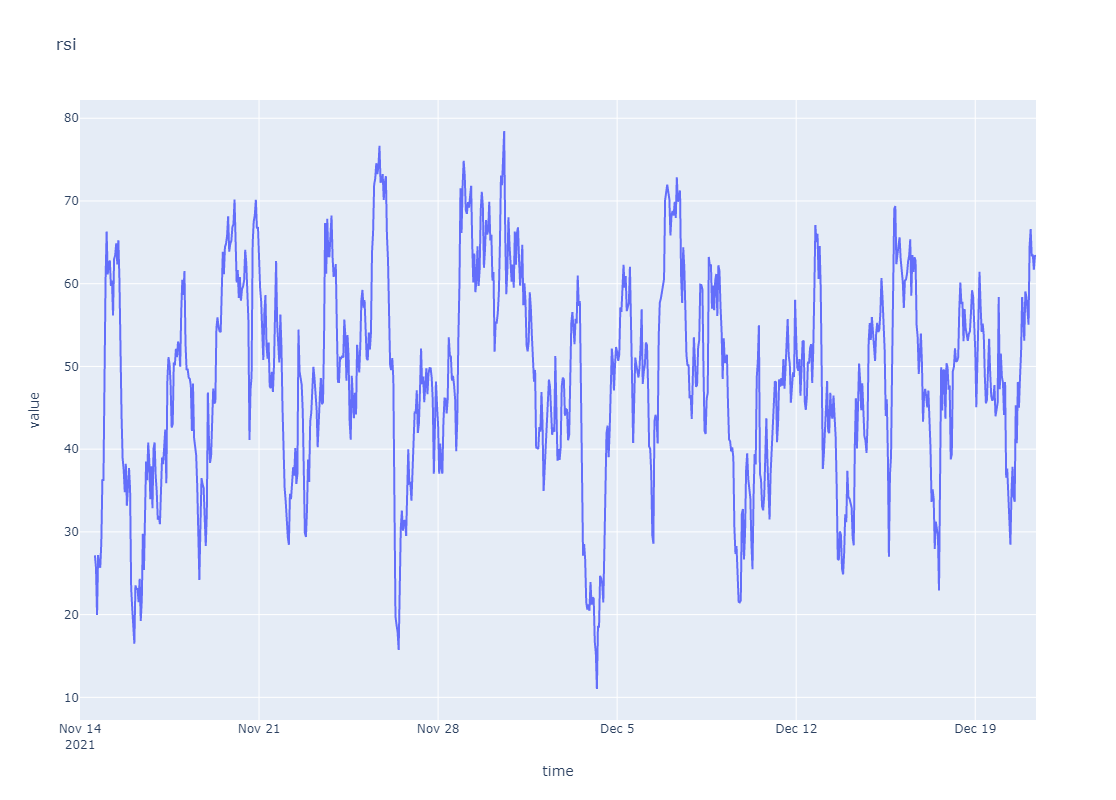

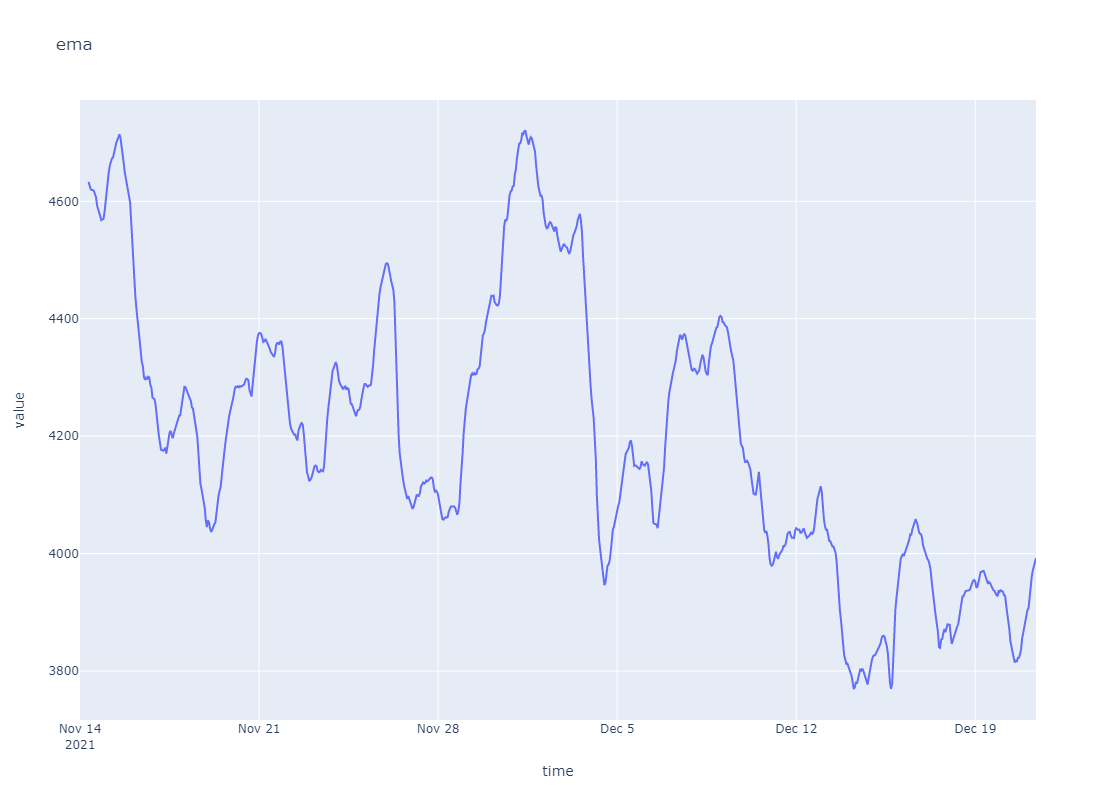

In [24]:
candles['rsi'] = ta.RSI(candles, timeperiod=14)
candles['ema'] = ta.EMA(candles, timeperiod=9)
plot_indicators(candles, ['rsi','ema'],  width=1500, height=800)

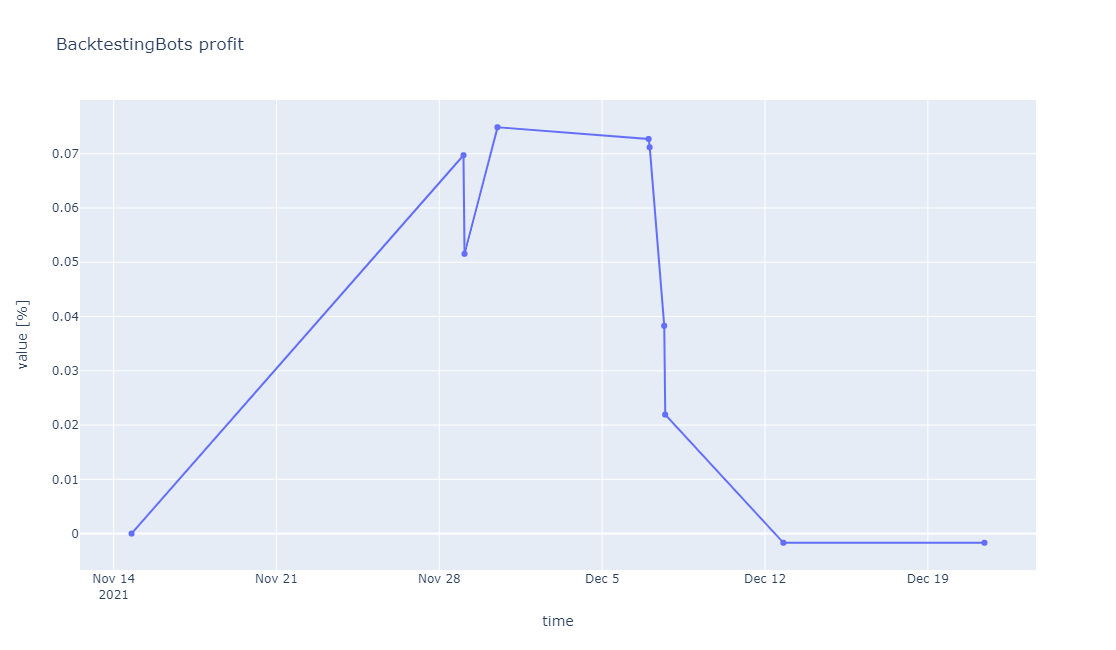

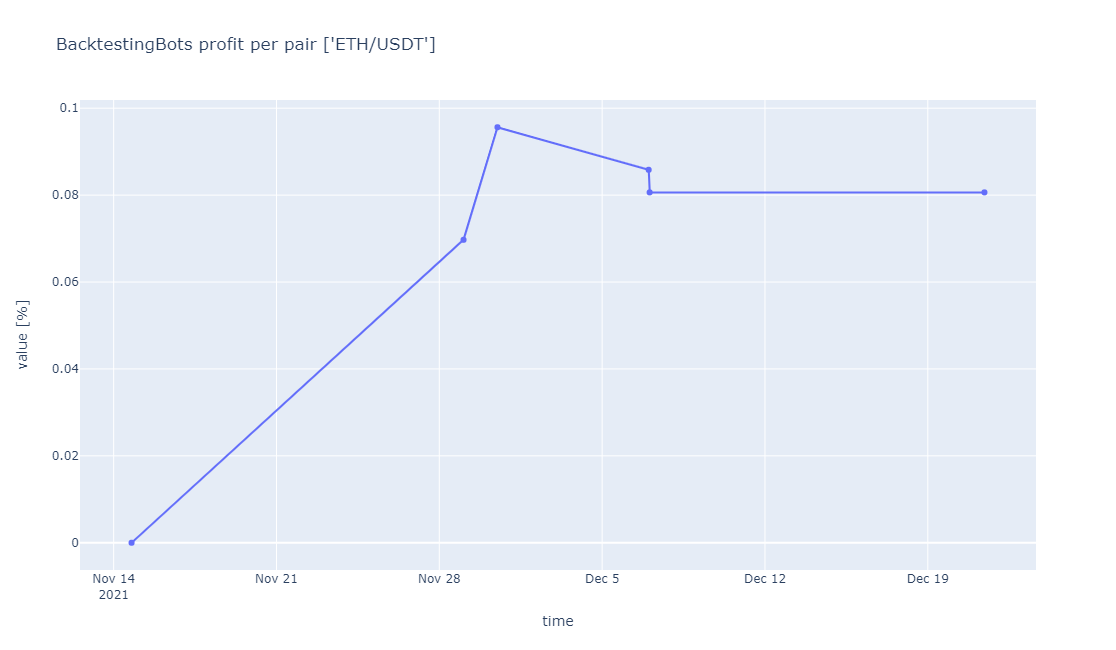

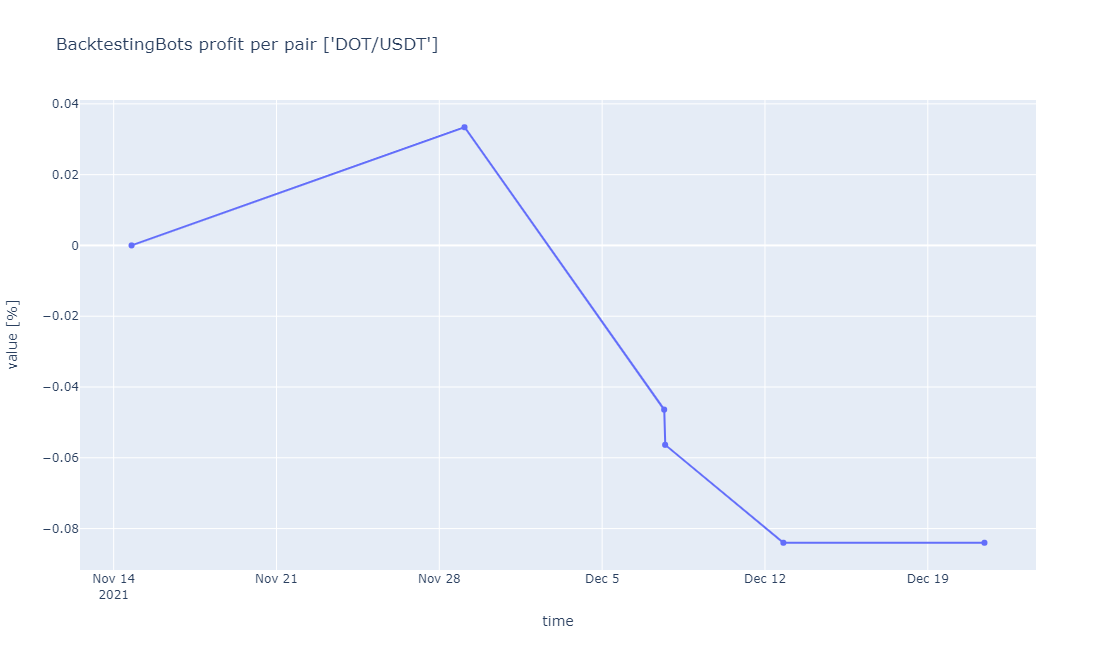

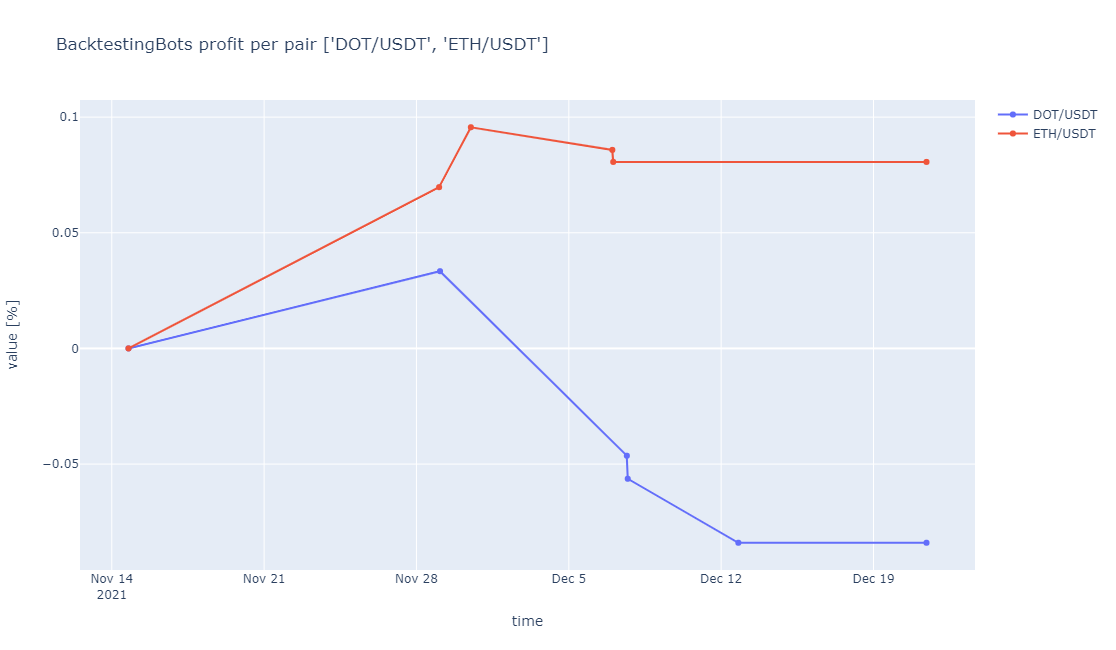

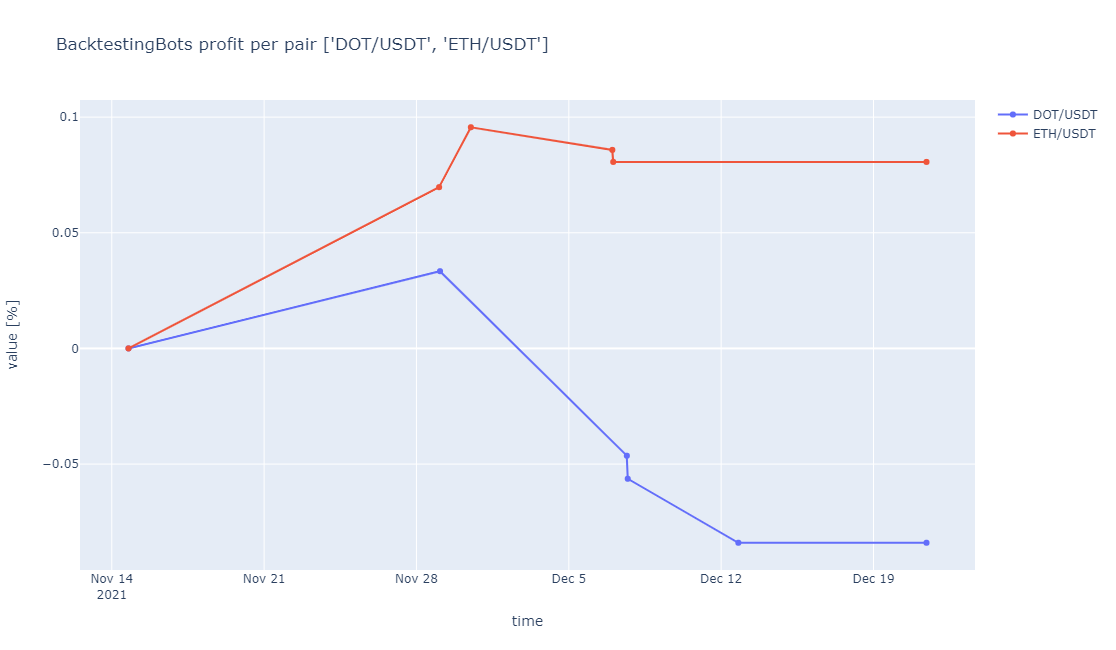

In [25]:
# plot_candles(candles: Dataframe, trades=None : AnalysisResult)
# plot_indicators(candles, ['rsi','ema'],  width=1500, height=850)
plot_profit(res0)
plot_profit_per_pair(res0, ["ETH/USDT"])
plot_profit_per_pair(res0, ['DOT/USDT'])
plot_profit_per_pair(res0, ['ETH/USDT', 'DOT/USDT'])
plot_profit_per_pair(res0)

In [26]:
def calc_indicators(candles):
        candles['rsi'] = ta.RSI(candles, timeperiod=14)
        candles['ema'] = ta.EMA(candles, timeperiod=9)
        return candles

def check_buy_signals(indicators):
    if (indicators.iloc[-1]['rsi'] < 50 and
        indicators.iloc[-2]['rsi'] < indicators.iloc[-1]['rsi']):
        return True
    else:
        return False

def check_sell_signals(indicators):
    if (indicators.iloc[-1]['rsi'] > 50 and
        indicators.iloc[-2]['rsi'] > indicators.iloc[-1]['rsi']):
        return True
    else:
        return False

fbot = FakeBot("simple_strategy/config.yml")
res0 = fbot.test_strategy(calc_indicators, check_buy_signals, check_sell_signals, last_n_days=20)

/tmp/ipykernel_67/1225881622.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_67/1225881622.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

